# Chargement des données

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!tar xzf /kaggle/input/shipsmano2021/ships.tgz
!ls /kaggle/working/ships_scaled/train

/kaggle/input/shipsmano2021/ships.tgz
/kaggle/input/ships-custom-test-data-set/ships_test/vsmallfish/1.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/vsmallfish/3.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/vsmallfish/2.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/coastguard/1.png
/kaggle/input/ships-custom-test-data-set/ships_test/coastguard/3.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/coastguard/2.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/submarine/1.png
/kaggle/input/ships-custom-test-data-set/ships_test/submarine/2.png
/kaggle/input/ships-custom-test-data-set/ships_test/submarine/4.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/submarine/3.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/cv/1.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/cv/4.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/cv/3.jpg
/kaggle/input/ships-custom-test-data-set/ships_test/cv/2.jpg
/kaggle/input/ships-custom-test-

# Générateur de données d'entrainement

Afin d'augmenter notre jeu de données déjà bien fournies, nous utilisons l'*ImageDataGenerator* de keras.
Celui-ci va créer un jeu de données d'entraînement ainsi qu'un jeu de donnée de test.

En plus de cela, et afin d'entraîner notre modèle sur des images de types et qualités différentes, le générateur va pouvoir modifier l'image en la déplançant à gauche, à droite, en haut et en bas. Il va également pouvoir zoomer sur l'image ou encore y effectuer une symétrie. Tout ceci va permettre à notre modèle d'apprendre beaucoup de cas différent.

Enfin, nous savons que le jeu de données d'entrainement fournis à un problème, certaines images sont en mode portrait pendant que d'autres sont en paysages. Cela pose problème puisque le générateur utilisé va devoir étirer ou rétrécir les images pour qu'elle soient toutes aux mêmes dimensions. Afin de contrer ce problème, nous avons décider de rétrécir les images jusqu'aux dimensions 85 par 85.

In [2]:
from keras.preprocessing.image import ImageDataGenerator 
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,     # Symétrie
        shear_range=0.1,          
        zoom_range=0.1,           # Zoom
        width_shift_range=0.1,    # Déplacement de l'image sur la largeur
        height_shift_range=0.1,   # Déplacement de l'image sur la hauteur
        validation_split=0.13)    # 13% des images seront utilisées pour la validation

# Création du data set d'entrainement
train_generator = train_datagen.flow_from_directory(
        'ships_scaled/train',
        target_size=(85, 85),     # Nouvelle taille de chaque image
        batch_size=batch_size,
        subset="training")

# Création du data set de validation
validation_generator = train_datagen.flow_from_directory(
        'ships_scaled/train',
        target_size=(85, 85),     # Nouvelle taille de chaque image
        batch_size=batch_size,
        subset="validation")

Found 41385 images belonging to 13 classes.
Found 6177 images belonging to 13 classes.


In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout2D, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Définition du modèle

Après de nombreuses recherches, nous avons défini un modèle composé principalement d'une suite de convolution. Afin que le modèle puisse prendre en compte et comprendre le plus possible d'information, la taille du filtre utilisé par ces convolutions augmente progressivement.

Entre chaqu'une de ces couches de convolution se situe des couches intermédiaires :
* *SpatialDropout2D* et *Dropout* ont pour but de prévenir et éviter le plus possible l'*overfitting*.
* *BatchNormalization* est utilisé pour normaliser les entrées entre des couches différentes.
* *MaxPool2D* permet d'effectuer un sous-échantillonnage.

Enfin, le réseau se termine par plusieurs couches denses afin de calculer le résultat.

In [4]:
model = Sequential()

# Convolution 64
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu', input_shape = (85, 85, 3)))
model.add(SpatialDropout2D(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolution 128
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# Convolution 256
model.add(Conv2D(filters = 256, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# Convolution 512
model.add(Conv2D(filters = 512, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())

# fully connected
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(13, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 85, 85, 64)        1792      
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 128)       0

# Configuration du modèle pour l'entrainement
* On utilise ici comme fonction de perte l'entropie croisée catégorielle, utilisée dans les tâches de classification multi-classes.
* Adam est un algorithme d'optimisation qui peut être utilisé à la place de la procédure classique de descente de gradient stochastique. En effet, il a été démontré comme étant plus efficace sur le plan calculatoire et usage mémoire.

In [5]:
from keras.optimizers import RMSprop,Adam
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

Si un modèle ou des poids pour ce modèle on déjà été calculés, nous pouvons les charger afin d'éviter un nouvel entrainement complet.

In [6]:
from keras.models import load_model

model_save_path = "save_model.h5"
weights_save_path = "save_weights.h5"

if os.path.isfile(model_save_path):
    model = load_model(model_save_path)
    print("Model saved loaded")
    
if os.path.isfile(weights_save_path):
    model.load_weights(weights_save_path)
    print("Weights saved load on model")

In [7]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  29


# Procédure d'entrainement du modèle

Afin d'éviter le sur-entrainement, nous utilisons un *EarlyStopping* qui va, dans le cas où le résultat sur le jeu de test stagne, arrêter l'entrainement automatiquement.

In [8]:
callback = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [9]:
history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=8, epochs=40, callbacks=[callback])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
1294/1294 [==============================] - 131s 97ms/step - loss: 2.5593 - accuracy: 0.1489 - val_loss: 2.2143 - val_accuracy: 0.2615
Epoch 2/40
1294/1294 [==============================] - 125s 96ms/step - loss: 2.0105 - accuracy: 0.3353 - val_loss: 1.5593 - val_accuracy: 0.4792
Epoch 3/40
1294/1294 [==============================] - 125s 96ms/step - loss: 1.5154 - accuracy: 0.4954 - val_loss: 1.2073 - val_accuracy: 0.5940
Epoch 4/40
1294/1294 [==============================] - 126s 97ms/step - loss: 1.1897 - accuracy: 0.6019 - val_loss: 1.0962 - val_accuracy: 0.6330
Epoch 5/40
1294/1294 [==============================] - 136s 105ms/step - loss: 0.9983 - accuracy: 0.6671 - val_loss: 0.8465 - val_accuracy: 0.7081
Epoch 6/40
1294/1294 [==============================] - 130s 100ms/step - loss: 0.8922 - accuracy: 0.6981 - val_loss: 0.8917 - val_accuracy: 0.6963
Epoch 7/40
1294/1294 [==============================] - 130s 100ms/step - loss: 0.7818 - accuracy: 0.7379 - val_loss

**Sauvegarde du modèle et des poids associées**

Afin d'éviter de devoir réeffectuer l'apprentissage à chaque fois, nous enregistrons les données du modèle et des poids calculés. Ils seront rechargés lors d'une exécution ultérieure.

In [10]:
model.save(model_save_path)
model.save_weights(weights_save_path)

# Résultats

Voici le graphique représentant l'historique de la précision du modèle tout au long de son apprentissage. Et ce, avec le jeu d'entraînement et le jeu de test.

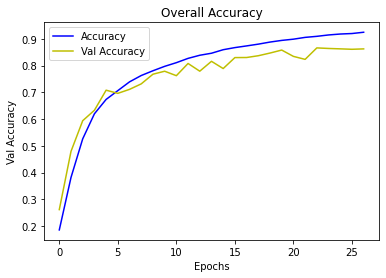

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='b', label="Accuracy")
plt.plot(history.history['val_accuracy'], color='y', label='Val Accuracy')
plt.title("Overall Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()

**Test et création des résultats pour la compétition Kaggle**

Les images doivent elles aussi être redimensionnées pour pouvoir être acceptée par le model.

In [12]:
import numpy as np
import pandas as pd
from skimage.transform import resize

X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

# Redimentionnement des images
new_shape = (85, 85, 3)
X_test_resized = []
for e in X_test:
    X_test_resized.append(resize(e, new_shape))
X_test_resized = np.asarray(X_test_resized)

In [13]:
res = model.predict(X_test_resized).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

!head reco_nav.csv

Id,Category
0,6
1,11
2,11
3,11
4,1
5,8
6,11
7,5
8,2


In [14]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

**Matrice de confusion sur le set de validation**

On affiche une matrice confusion des résultats obtenus sur les images du 1er batch (32 images)

True label (category) values:  [ 9  1  1 10  3  9  5  0 10 12  1  5 12  4 11 11 11 12 11  5  5 10 12  2
  9  3  3  1  7  5  1 12]
Predicted label values:  [ 9  1  1 10  3  9  0 12 10  9  1  5 12  4 11 11 11 12 11  5  5  6 11  2
  9  3  3  1  7  5  1 12]


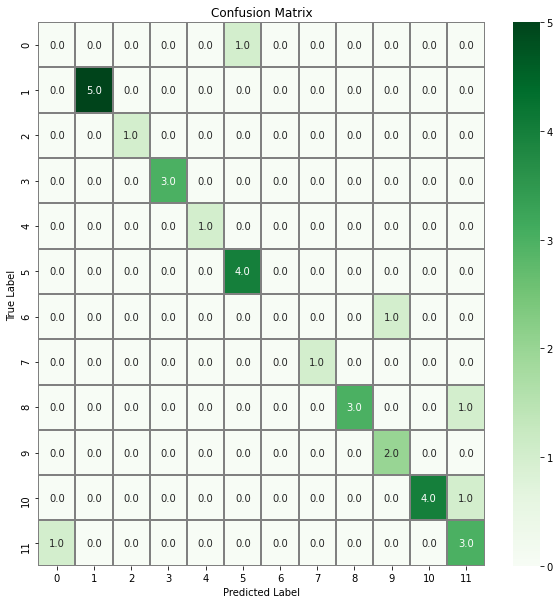

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def compute_confusion(x, y_true):
    # Normalize Data
    max_value = float(x.max())
    x = x.astype('float32') / max_value
    
    """
    model.predict(x) prend un batch de 32 images normalisées 
    predict renvoie pour chaque image un array de 13 probabilités
    on récupère la probabilité maximale (=classe la plus probable selon la prédiction faite par le modèle)
    """
    res = model.predict(x).argmax(axis=1)
    
    # y_true est une matrice 32 * 13 tout comme res
    # sauf qu'ici les probabilités sont certaines pour chaque image [0, .., 1, ..]
    y_true = np.argmax(y_true, axis=1) 

    print("True label (category) values: ", res)
    print("Predicted label values: ", y_true)

    confusion_mtx = confusion_matrix(y_true, res) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
(x, y_true) = validation_generator.next() # returns batch size (32) test samples
compute_confusion(x, y_true)

**Test dataset evaluation**

A partir d'un dataset fait maison, on cherche à évaluer l'efficacité du modèle.

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/kaggle/input/ships-custom-test-data-set/ships_test/',
        target_size=(85, 85),
        batch_size=batch_size)

test_res = model.evaluate_generator(test_generator, workers=8, use_multiprocessing=True, verbose=1)
print("Test loss = {0} || Test accuracy {1}".format(test_res[0], test_res[1]))

Found 48 images belonging to 13 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


2/2 [==============================] - 2s 535ms/step - loss: 1.6946 - accuracy: 0.6458
Test loss = 1.6945840120315552 || Test accuracy 0.6458333134651184


**Matrice de confusion sur le set de test**

True label (category) values:  [12  8 10 12 11 12  2 12  2  4  2 11  2  2  5  6  5 11 10  7  7  1  2  6
  6  8  4 10 12  4  1  4]
Predicted label values:  [ 9  8 10 11 11 12  2  7  3  4  5 11  3  2  5  6  5 11 10  7  7  1  2  6
  6  8  4 10  9  4  1  4]


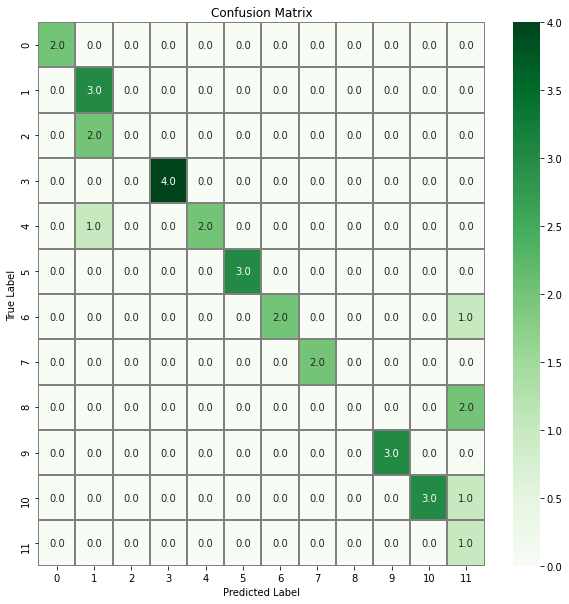

In [17]:
(x, y_true) = test_generator.next() # returns batch size (32) test samples
compute_confusion(x, y_true)

Cleaning

In [18]:
!rm -rf ships_scaled/